# Personally Identifiable Information (PII) Data Detec

#### The dataset comprises approximately 22,000 essays written by students enrolled in a massively open online course. All of the essays were written in response to a single assignment prompt, which asked students to apply course material to a real-world problem. 

#### The goal is to annotate personally identifiable information (PII) found within the essays.

#### There are seven types of PII:

* *NAME_STUDENT* - The full or partial name of a student that is not necessarily the author of the essay. This excludes instructors, authors, and other person names.
* *EMAIL* - A student’s email address.
* *USERNAME* - A student's username on any platform.
* *ID_NUM* - A number or sequence of characters that could be used to identify a student, such as a student ID or a social security number.
* *PHONE_NUM* - A phone number associated with a student.
* *URL_PERSONAL* - A URL that might be used to identify a student.
* *STREET_ADDRESS* - A full or partial street address that is associated with the student, such as their home address.

In [69]:
import os

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import json

In [70]:
class InputData:
    train = "input/train.json"
    test = "input/test.json"

In [71]:
train_data = pd.read_json(InputData.train)
test_data = pd.read_json(InputData.test)
all_data = pd.concat([train_data, test_data])

print(f"train data shape: {train_data.shape}")
print(f"test data shape: {test_data.shape}")
print(f"total shape of data: {all_data.shape}")

train data shape: (6807, 5)
test data shape: (10, 4)
total shape of data: (6817, 5)


In [72]:
all_data.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [73]:
all_data.tokens[0].values[0][:12]

['Design',
 'Thinking',
 'for',
 'innovation',
 'reflexion',
 '-',
 'Avril',
 '2021',
 '-',
 'Nathalie',
 'Sylla',
 '\n\n']

In [74]:
all_data.labels[0].values[0][:12]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NAME_STUDENT',
 'I-NAME_STUDENT',
 'O']

In [75]:
# Unique labels in dataframe
unique_labels = set()
for row in range(len(train_data)):
    unique_labels = unique_labels.union(set(train_data.iloc[row].labels))
print(unique_labels)

{'B-STREET_ADDRESS', 'O', 'B-USERNAME', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-ID_NUM', 'B-NAME_STUDENT', 'I-URL_PERSONAL', 'B-EMAIL', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-PHONE_NUM', 'B-ID_NUM'}


In [76]:
# QTY of unique labels in dataframe
train_label_count = dict()
for row in range(len(train_data)):
    for label in train_data.iloc[row].labels:
        train_label_count[label] = train_label_count.get(label, 0) + 1
train_label_count = dict(sorted(train_label_count.items(), key=lambda x: x[1], reverse=True))
        
print('Quantity of each label:')
print(train_label_count)

Quantity of each label:
{'O': 4989794, 'B-NAME_STUDENT': 1365, 'I-NAME_STUDENT': 1096, 'B-URL_PERSONAL': 110, 'B-ID_NUM': 78, 'B-EMAIL': 39, 'I-STREET_ADDRESS': 20, 'I-PHONE_NUM': 15, 'B-USERNAME': 6, 'B-PHONE_NUM': 6, 'B-STREET_ADDRESS': 2, 'I-URL_PERSONAL': 1, 'I-ID_NUM': 1}


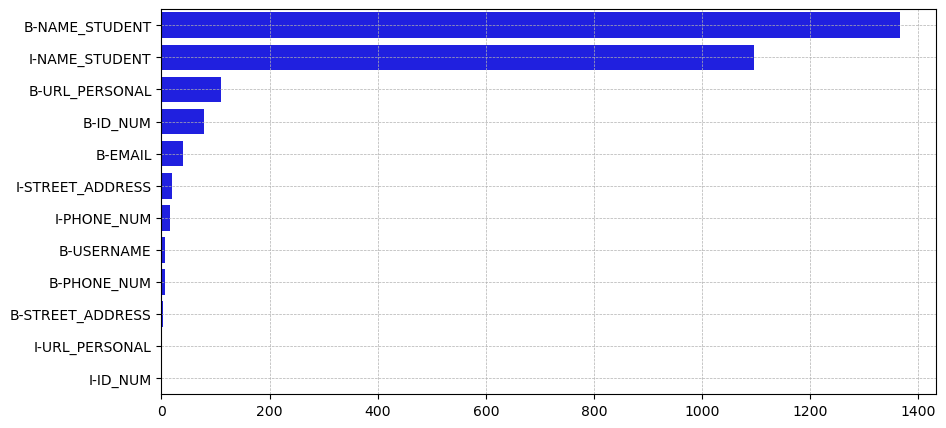

In [77]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(train_label_count.values())[1:], y=list(train_label_count.keys())[1:], color='blue')
plt.grid(True, linestyle='--', linewidth=0.5)

In [78]:
entities = [ent for ent in set([key[2:] for key in train_label_count]) - {''}]
print(entities)

['EMAIL', 'STREET_ADDRESS', 'ID_NUM', 'NAME_STUDENT', 'URL_PERSONAL', 'PHONE_NUM', 'USERNAME']


In [79]:
distr_of_labels = {
    'begin': [train_label_count.get('B-'+i,0) for i in entities],
    'end': [train_label_count.get('I-'+i,0) for i in entities]
                  }
distr_of_labels_df = pd.DataFrame(data=distr_of_labels, index=entities)
distr_of_labels_df

,begin,end
EMAIL,39,0
STREET_ADDRESS,2,20
ID_NUM,78,1
NAME_STUDENT,1365,1096
URL_PERSONAL,110,1
PHONE_NUM,6,15
USERNAME,6,0


In [80]:
from collections import Counter
from spacy.tokens import Doc
nlp = spacy.blank('en')

def find_first_occurence(entity_):
    for i in range(len(train_data)):
        train_label_count_ = Counter(train_data.iloc[i]['labels'])
        if 'B-'+entity_ in train_label_count_:
            break
    return i

def render_entities(record_):
    doc = Doc(nlp.vocab, words=record_['tokens'], spaces=record_['trailing_whitespace'], ents=record_['labels'])
    spacy.displacy.render(doc, style='ent')
render_entities(train_data.iloc[28])

Text(0.5, 1.0, 'Articles with and without labels')

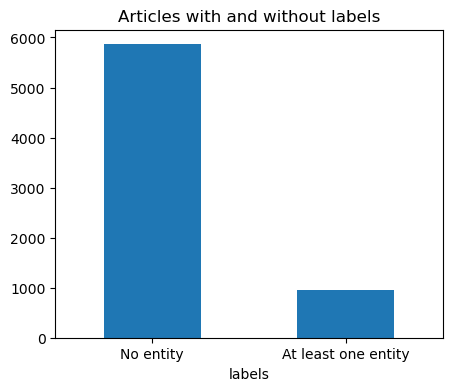

In [ ]:
plt.figure(figsize=(5,4))
train_data['labels'].apply(lambda x: "No entity" if set(x) == {"O"} else "At least one entity").value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title("Articles with and without labels")
#